Support Vector Machine Model

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [8]:
df = pd.read_csv('BTC USD Data.csv')

print(df.head())

                        Date        Open        High         Low       Close  \
0  2014-09-17 00:00:00+00:00  465.864014  468.174011  452.421997  457.334015   
1  2014-09-18 00:00:00+00:00  456.859985  456.859985  413.104004  424.440002   
2  2014-09-19 00:00:00+00:00  424.102997  427.834991  384.532013  394.795990   
3  2014-09-20 00:00:00+00:00  394.673004  423.295990  389.882996  408.903992   
4  2014-09-21 00:00:00+00:00  408.084991  412.425995  393.181000  398.821014   

     Volume  Dividends  Stock Splits  
0  21056800        0.0           0.0  
1  34483200        0.0           0.0  
2  37919700        0.0           0.0  
3  36863600        0.0           0.0  
4  26580100        0.0           0.0  


Rows with invalid date format: 0
Filtered labels distribution: {-1: 1756, 1: 1972}
Accuracy: 0.6742627345844504


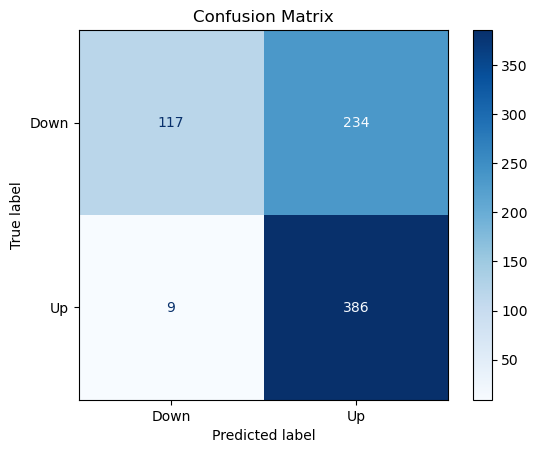

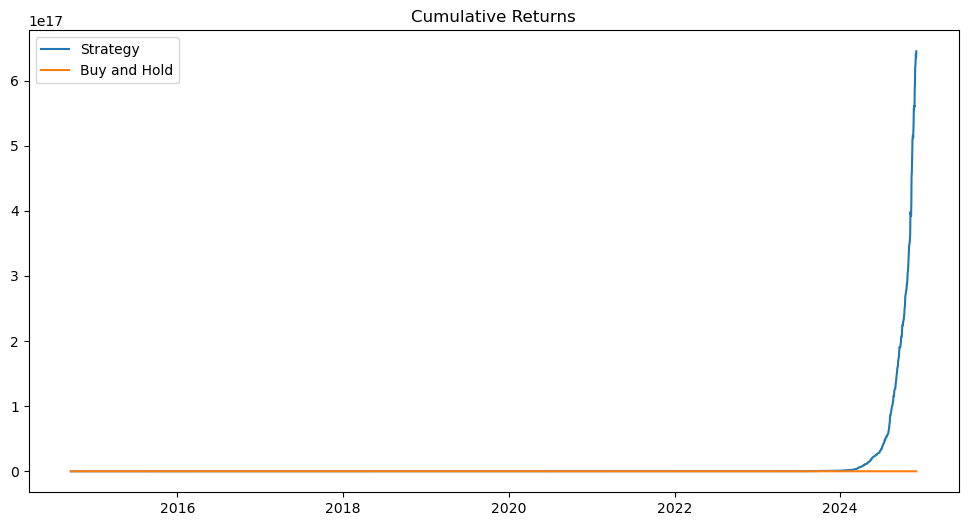

In [9]:
# Convert 'Date' to datetime with timezone information preserved
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Check for any errors in date conversion (this step will show if any rows have invalid date formats)
print(f"Rows with invalid date format: {df['Date'].isna().sum()}")  # Check how many NaN values are in 'Date' after conversion

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Feature engineering (assuming no further data issues)
df['Pct_Change'] = df['Close'].pct_change()  # Daily percentage change
df['Target'] = np.sign(df['Pct_Change']).shift(-1)  # Price movement: 1 (up), -1 (down)

# Drop NaN values that appeared due to pct_change or target shift
df.dropna(inplace=True)

# Create labels: 1 for price increase, -1 for price decrease, 0 for no change
df['Label'] = 0
df.loc[df['Pct_Change'] > 0, 'Label'] = 1
df.loc[df['Pct_Change'] < 0, 'Label'] = -1

# Prepare features and labels
features = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
labels = df['Label']

# Filter out samples where the label is 0.0 (if needed, or if it still exists with very few samples)
mask = labels != 0.0
filtered_features = features[mask]
filtered_labels = labels[mask]

# Check the distribution of the filtered labels
unique, counts = np.unique(filtered_labels, return_counts=True)
print(f"Filtered labels distribution: {dict(zip(unique, counts))}")

# Apply feature scaling using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(filtered_features)  # Scale the features

# Train-test split with scaled features
X_train, X_test, y_train, y_test = train_test_split(scaled_features, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels)

# Apply SMOTE to balance the training set
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the SVM on the resampled data
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = svm.predict(X_test)

# Output the accuracy of the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# Backtest the trading strategy using the model's predictions
df['Prediction'] = svm.predict(scaler.transform(features))  # Use the scaled features for prediction

# Simulate trading (assuming daily percentage change is a valid trading return metric)
df['Strategy_Returns'] = df['Prediction'] * df['Pct_Change']  # Strategy returns
df['Cumulative_Strategy'] = (1 + df['Strategy_Returns']).cumprod()
df['Cumulative_Buy_and_Hold'] = (1 + df['Pct_Change']).cumprod()

# Plot the cumulative returns for strategy vs. buy and hold
plt.figure(figsize=(12, 6))
plt.plot(df['Cumulative_Strategy'], label='Strategy')
plt.plot(df['Cumulative_Buy_and_Hold'], label='Buy and Hold')
plt.legend()
plt.title('Cumulative Returns')
plt.show()

